Cloning into 'geometric-cnn-assignment'...
remote: Enumerating objects: 30024, done.
remote: Counting objects: 100% (30024/30024), done.
remote: Compressing objects: 100% (25401/25401), done.
remote: Total 30024 (delta 4621), reused 30008 (delta 4621), pack-reused 0 (from 0)
Receiving objects: 100% (30024/30024), 21.72 MiB | 10.77 MiB/s, done.
Resolving deltas: 100% (4621/4621), done.
Updating files: 100% (30013/30013), done.
Using device: cuda
Classes found: ['Circle', 'Square', 'Triangle']
Starting Training...
Epoch 1/10 - Val Acc: 68.87%
Epoch 2/10 - Val Acc: 90.67%
Epoch 3/10 - Val Acc: 94.77%
Epoch 4/10 - Val Acc: 97.32%
Epoch 5/10 - Val Acc: 97.78%
Epoch 6/10 - Val Acc: 98.55%
Epoch 7/10 - Val Acc: 98.77%
Epoch 8/10 - Val Acc: 98.95%
Epoch 9/10 - Val Acc: 98.77%
Epoch 10/10 - Val Acc: 98.38%
Model saved as 200109.pth


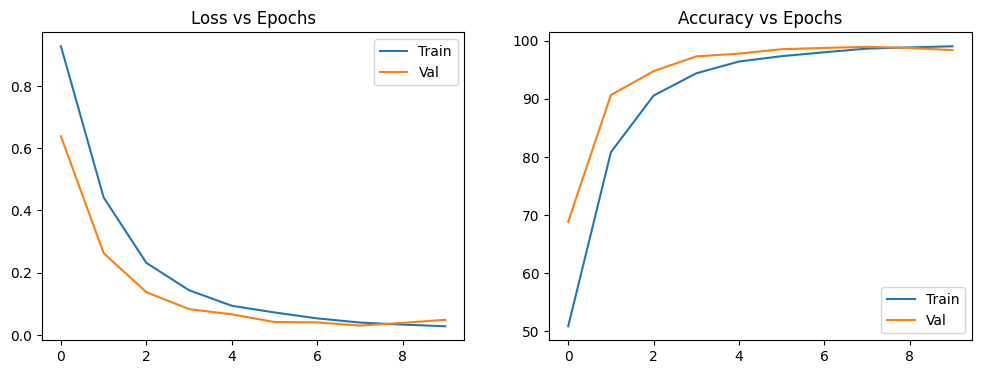

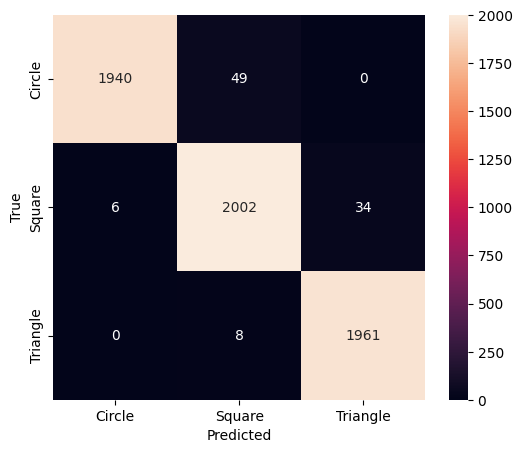

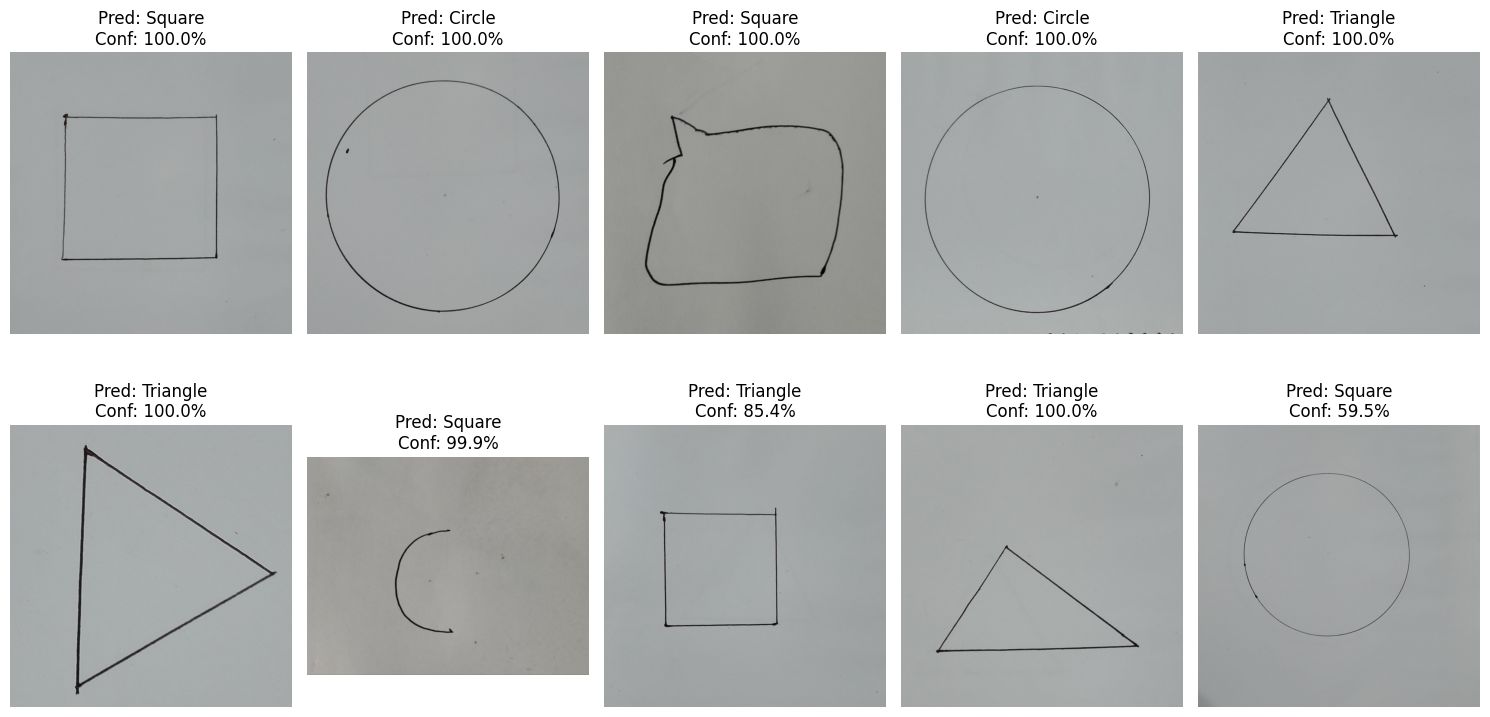

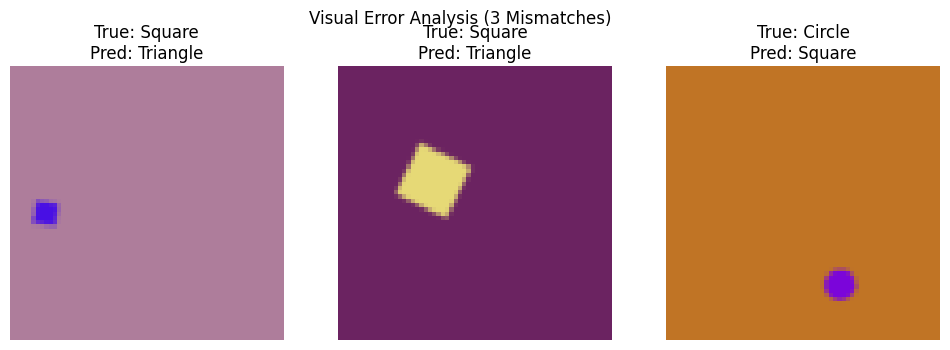

In [2]:
# @title CNN Image Classification Assignment - ID: 190110 (Replace with yours)
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import os
import shutil
from PIL import Image
from sklearn.metrics import confusion_matrix
import seaborn as sns

# ==========================================
# 1. SETUP & AUTOMATION
# ==========================================
ID = "200109" # Replace with your Student ID
REPO_URL = "https://github.com/SNBappy/geometric-cnn-assignment.git"
REPO_NAME = "geometric-cnn-assignment"

# Clean up and Clone Repository
if os.path.exists(REPO_NAME):
    shutil.rmtree(REPO_NAME)
!git clone {REPO_URL}

# Set Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# ==========================================
# 2. DATA PREPROCESSING
# ==========================================
# Geometric shapes are usually simple, 64x64 or 128x128 is perfect
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5]) # Mean/Std for RGB
])

# Load Kaggle Dataset (Assuming it's in training_data folder in repo)
train_dir = f"{REPO_NAME}/training_data"
full_dataset = datasets.ImageFolder(train_dir, transform=transform)

# Split into Train and Validation (80/20)
train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(full_dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

class_names = full_dataset.classes # ['circle', 'square', 'triangle']
print(f"Classes found: {class_names}")

# ==========================================
# 3. MODEL ARCHITECTURE
# ==========================================
class ShapeCNN(nn.Module):
    def __init__(self):
        super(ShapeCNN, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )
        self.fc_layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64 * 8 * 8, 128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, 3) # 3 classes: Circle, Square, Triangle
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = self.fc_layers(x)
        return x

model = ShapeCNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# ==========================================
# 4. TRAINING LOOP
# ==========================================
epochs = 10
history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': []}

print("Starting Training...")
for epoch in range(epochs):
    model.train()
    running_loss, correct = 0.0, 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()

    # Validation
    model.eval()
    val_loss, val_correct = 0.0, 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            val_correct += (predicted == labels).sum().item()

    # Store History
    history['train_loss'].append(running_loss/len(train_loader))
    history['val_loss'].append(val_loss/len(val_loader))
    history['train_acc'].append(100 * correct/len(train_dataset))
    history['val_acc'].append(100 * val_correct/len(val_dataset))

    print(f"Epoch {epoch+1}/{epochs} - Val Acc: {history['val_acc'][-1]:.2f}%")

# Save the model
model_save_path = f"{ID}.pth"
torch.save(model.state_dict(), model_save_path)
print(f"Model saved as {model_save_path}")

# ==========================================
# 5. VISUALS: LOSS/ACCURACY & CONFUSION MATRIX
# ==========================================
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history['train_loss'], label='Train')
plt.plot(history['val_loss'], label='Val')
plt.title('Loss vs Epochs')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history['train_acc'], label='Train')
plt.plot(history['val_acc'], label='Val')
plt.title('Accuracy vs Epochs')
plt.legend()
plt.show()

# Confusion Matrix
model.eval()
all_preds, all_labels = [], []
with torch.no_grad():
    for images, labels in val_loader:
        outputs = model(images.to(device))
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.numpy())

cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# ==========================================
# 6. REAL-WORLD TESTING (10 PHONE PHOTOS)
# ==========================================
custom_img_path = f"{REPO_NAME}/dataset"
custom_images = [f for f in os.listdir(custom_img_path) if f.endswith(('.jpg', '.png', '.jpeg'))][:10]

plt.figure(figsize=(15, 8))
model.eval()

for i, img_name in enumerate(custom_images):
    img_raw = Image.open(os.path.join(custom_img_path, img_name)).convert('RGB')
    img_t = transform(img_raw).unsqueeze(0).to(device)

    with torch.no_grad():
        output = model(img_t)
        prob = torch.softmax(output, dim=1)
        conf, pred = torch.max(prob, 1)

    plt.subplot(2, 5, i+1)
    plt.imshow(img_raw)
    plt.title(f"Pred: {class_names[pred.item()]}\nConf: {conf.item()*100:.1f}%")
    plt.axis('off')
plt.tight_layout()
plt.show()

# ==========================================
# 7. VISUAL ERROR ANALYSIS (3 INCORRECT)
# ==========================================
errors = []
model.eval()
with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        for j in range(len(preds)):
            if preds[j] != labels[j]:
                errors.append((images[j].cpu(), labels[j].cpu(), preds[j].cpu()))
            if len(errors) >= 3: break
        if len(errors) >= 3: break

plt.figure(figsize=(12, 4))
for i in range(len(errors)):
    img, true_lab, pred_lab = errors[i]
    img = img.permute(1, 2, 0) * 0.5 + 0.5 # Unnormalize
    plt.subplot(1, 3, i+1)
    plt.imshow(img)
    plt.title(f"True: {class_names[true_lab]}\nPred: {class_names[pred_lab]}")
    plt.axis('off')
plt.suptitle("Visual Error Analysis (3 Mismatches)")
plt.show()